In [17]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from IPython.display import clear_output 
from statsmodels.graphics import tsaplots

# Hearts : a mixture model for count data  
On etude l'effet des médicaments administrés à des patients atteints d'anomalie au niveau du coeur. Ces patients ont des contractions prématurées du ventricule droit du coeur (PVC's) et le but c'est qu'après prise des médicaments, on ne décompte plus de PVC's.  

On definit $t_i$ la variable qui décompte le nombre de PVC's pour le patient $i$ dans le temps et $Yi$ la variable qui décompte le nombre de PVC's après prise des médicaments pour le patient $i$. Toutes deux suivent une loi de Poisson et le conditionnement $Y_i|t_i$ defini une $\mathcal{B}in(p, t_i)$.  
Cependant, décompter aucun PVC's ne signifie pas forcement que le patients guéri, on introduit dont une variable $Z \sim \mathcal{B}(\theta)$ supplémentaire qui indique si le patient est guéri avec une probabilité $\theta$. 

On obtient donc le modèle de mélange suivant :
$$ P(y_i, z | ti, \theta, p) = \theta + (1-\theta)(1-p)^{t_i} \quad \text{si} \ y_i = 0$$ 
$$ P(y_i, z | ti, \theta, p) = (1-\theta) \frac{t_i!}{y_i! (t_i-y_i)!} p^{y_i} (1-p)^{t_i-y_i} \quad \text{si} \ y_i \ne 0 $$

Pour pouvoir échantilloner dans tout $\mathbb{R}$ selon les lois a posteriori de $\theta$ et $p$, on définit une relation logit avec le paramètre $\delta$ et $\alpha$
$$ logit(\theta) = \delta \quad \text{et} \quad  logit(p) = \alpha $$


In [6]:
#nombre d'individus 
n_obs = 12
#PVC total
PVC_tot = np.array([11, 11, 17, 22, 9, 6, 5, 14, 9, 7, 22, 51])

#avant médicaments  
before_drugs = np.array([6, 9, 17, 22, 7, 5, 5, 14, 9, 7, 9, 51])

#après médicaments 
after_drugs = np.array([5, 2, 0, 0, 2, 1, 0, 0, 0, 0, 13, 0])

hearts = np.vstack((PVC_tot, before_drugs, after_drugs))
hearts = hearts.T
print("-------------- Hearts data ------------------------")
print(pd.DataFrame(hearts, columns = ["PVC_tot", "before_drugs", "after_drugs"]))

-------------- Hearts data ------------------------
    PVC_tot  before_drugs  after_drugs
0        11             6            5
1        11             9            2
2        17            17            0
3        22            22            0
4         9             7            2
5         6             5            1
6         5             5            0
7        14            14            0
8         9             9            0
9         7             7            0
10       22             9           13
11       51            51            0


In [7]:
def Gibbs(nchain, data, sd_alpha, sd_delta, init, sigma_alpha, sigma_delta, burning, lag= 10):
    #init
    chain = np.zeros((nchain+1,2)) #alpha, delta 
    chain[0, :] = init
    
    #observation
    tot = data[:, 0]
    before  = data[:, 1]
    after = data[:, 2]
    N = len(tot)
    ########
    prob_accep = 0
    
    for i in range(nchain):
        ######### MAJ alpha ############
        new_candidate = chain[i, 0] + np.random.normal(scale= sd_alpha)
        
        top = -(new_candidate**2 / (2*sigma_alpha**2)) \
            + (np.log(np.exp(chain[i, 1])+(1+np.exp(new_candidate))**(-tot[(after == 0)] ) )).sum() \
                + new_candidate* ((after[(after != 0)])).sum() - np.log(1+np.exp(new_candidate))*(tot[(after !=0)]).sum()
            
        bottom = -(chain[i, 0]**2 / (2*sigma_alpha**2))   \
            + (np.log(np.exp(chain[i, 1])+(1+np.exp(chain[i, 0]))**(-tot[(after == 0)]))).sum() \
                + (chain[i, 0]*(after[(after != 0)])).sum() - np.log(1+np.exp(chain[i,0]))*(tot[(after !=0)]).sum()
        ratio = top -bottom

        
        u = np.log(np.random.uniform())
        if u < ratio :
            chain[i+1, 0] = new_candidate
            prob_accep += 1
        else:
            chain[i+1, 0] = chain[i, 0]
        
        ############## MAJ delta ################# 
        new_candidate = chain[i, 1] + np.random.normal(scale= sd_delta)
        
        top = -(new_candidate**2 / (2* sigma_delta**2)) - N * np.log(1+np.exp(new_candidate)) \
            + np.sum(np.log(np.exp(new_candidate) + (1+np.exp(chain[i+1, 0]))**(-tot[(after == 0)] ) ))
        
            
        bottom = -(chain[i, 1]**2 / (2*sigma_delta**2)) - N * np.log(1+np.exp(chain[i, 1])) \
            + np.sum(np.log(np.exp(chain[i, 1]) + (1+np.exp(chain[i+1, 0]))**(-tot[(after == 0)] ) ))
        
        ratio = top - bottom
        #print(ratio)
        u = np.log(np.random.uniform())
        if u < ratio :
            chain[i+1, 1] = new_candidate
            prob_accep += 1
        else:
            chain[i+1, 1] = chain[i, 1]
    #####################
        if i % 1000 == 0:
            clear_output(wait = True)
            print(f"Iteration : {i}")
        
    #burning and lag 
    index_simu = np.arange(burning, nchain+1, lag)
    chain = chain[index_simu, :]
    return chain, prob_accep/(2*nchain)
    
        
        
    

## Simualtions par algorithme de MCMC avec echantillonneur de Gibbs
On simule 3 chaines avec 3 initialisationde $\alpha, \delta$ différentes (on utilise la distribution normal de variance 25)

Iteration : 10000


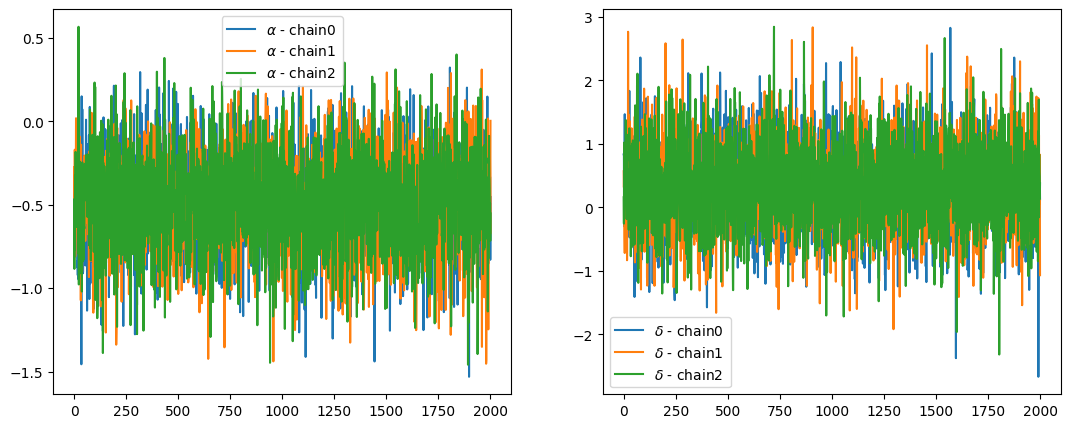

In [16]:
sd_alpha = 1 
sd_delta = 1
#init = np.array([0,0])
sigma_alpha, sigma_delta = 10000, 10000
fig, ax = plt.subplots(1,2, figsize = (13,5))
for i in range(3):
    simu, accep = Gibbs(11000, hearts, sd_alpha, sd_delta, np.random.normal(size=(1,2), scale = 5), sigma_alpha, sigma_delta, burning= 1000, lag = 5)
    ax[0].plot(simu[:, 0], label = r'$\alpha$ - chain%d '%i);
    ax[1].plot(simu[:, 1], label = r'$\delta$ - chain%d '%i);
ax[0].legend()
ax[1].legend();

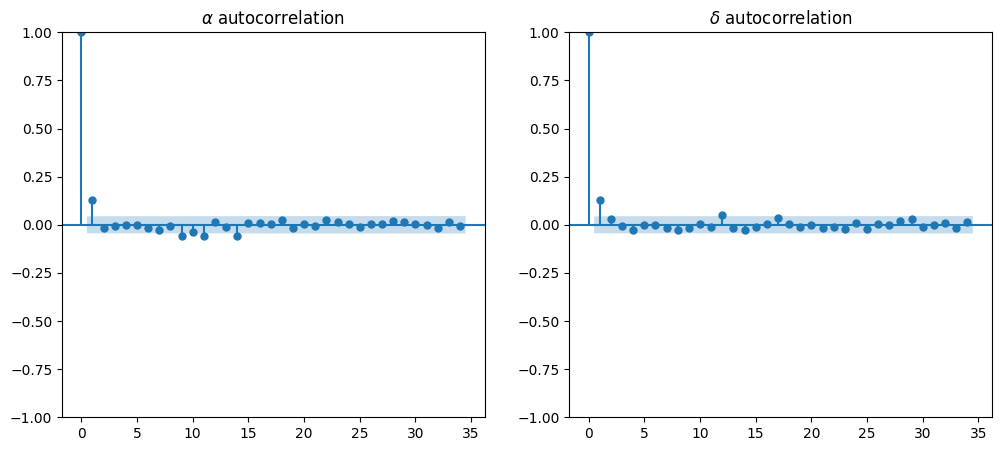

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))
autocorr_theta1 = tsaplots.plot_acf(simu[:, 0], ax=ax1, title= r"$\alpha$ autocorrelation")
autocorr_theta2 = tsaplots.plot_acf(simu[:, 1], ax=ax2, title= r"$\delta$ autocorrelation")

In [14]:
print(f"probabilité d'acceptation: {round(accep,2)}")

probabilité d'acceptation: 0.44


Les chaines se superposent et l'autocorrélation pour les deux paramètres sont très faibles. On a donc des chaines qui mélangent bien et par conséquent qui explorent l'espace de définition des densités à posteriori mais aussi des chaines très peu corrélés. 

In [19]:
#Calcul des distribution pour les paramètres p et theta 
theta = (1+np.exp(-simu[:, 1]))**(-1)
p = (1+np.exp(-simu[:, 0]))**(-1)

In [20]:
#Tableau résumé : statistiques des différents paramètres ?
print("-------------------------------------------------------------------------------")
print(f"Estimateur en moyenne de alpha {round(np.mean(simu[: , 0]), 2)} et variance de la loi a posteriori {round(np.std(simu[: , 0]), 2)}")
print(f"Estimateur en moyenne de delta {round(np.mean(simu[: , 1]),2)} et variance de la loi a posteriori {round(np.std(simu[: , 1]),2)}")
print(f"Estimateur en moyenne de p {round(np.mean(p),2)} et variance de la loi a posteriori {round(np.std(p),2)}")
print(f"Estimateur en moyenne de theta {round(np.mean(theta),2)} et variance de la loi a posteriori {round(np.std(theta),2)}")

-------------------------------------------------------------------------------
Estimateur en moyenne de alpha -0.48 et variance de la loi a posteriori 0.28
Estimateur en moyenne de delta 0.32 et variance de la loi a posteriori 0.63
Estimateur en moyenne de p 0.38 et variance de la loi a posteriori 0.06
Estimateur en moyenne de theta 0.57 et variance de la loi a posteriori 0.14


## Tracé des densités

In [21]:
import scipy.stats as stats
alpha_density = stats.gaussian_kde(simu[:, 0])
delta_density = stats.gaussian_kde(simu[:, 1])
p_density = stats.gaussian_kde(p)
theta_density = stats.gaussian_kde(theta)

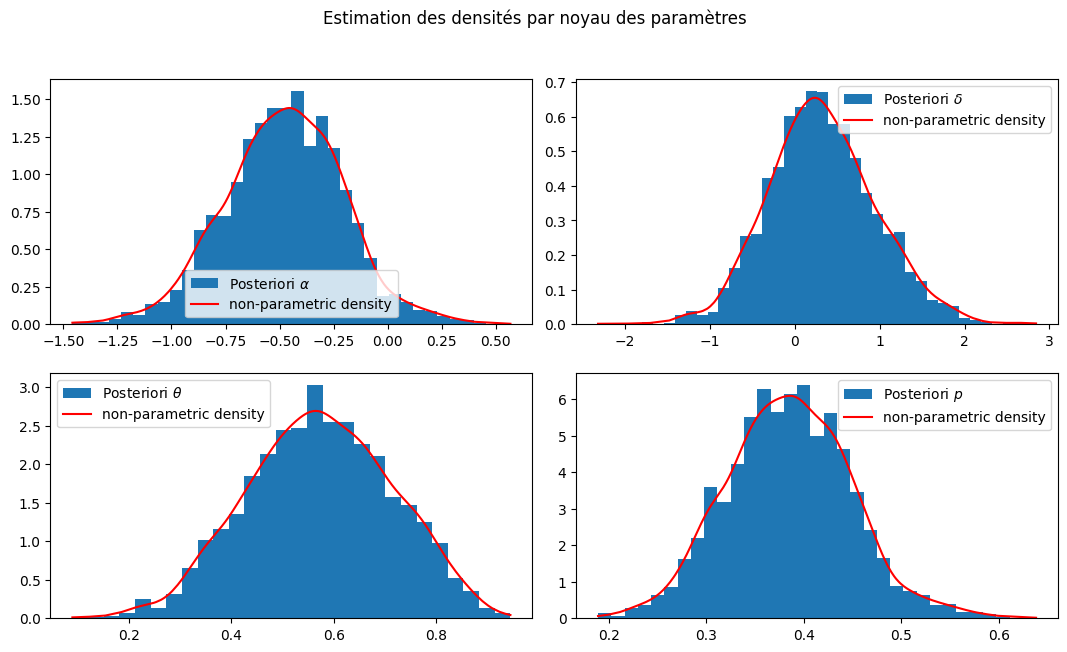

In [27]:
fig, ax = plt.subplot_mosaic([["A","A", "B","B"], ["C","C", "D", "D"]], figsize = (13, 7))
fig.suptitle("Estimation des densités par noyau des paramètres ")
ax["A"].hist(simu[:, 0], label= r"Posteriori $\alpha$", bins = 'auto', density = True)
ax["A"].plot(np.sort(simu[:, 0]), alpha_density(np.sort(simu[:, 0])), color = 'red', label = r"non-parametric density")
ax["A"].legend()
ax["B"].hist(simu[:, 1], label= r"Posteriori $\delta$", bins = 'auto', density = True)
ax["B"].plot(np.sort(simu[:, 1]), delta_density(np.sort(simu[:, 1])), color = 'red', label = r"non-parametric density")
ax["B"].legend()
ax["C"].hist(theta, label = r"Posteriori $\theta$", bins = 'auto', density = True)
ax["C"].plot(np.sort(theta), theta_density(np.sort(theta)), color = 'red', label = r"non-parametric density")
ax["C"].legend()
ax["D"].hist(p, label= r"Posteriori $p$", bins = 'auto', density = True)
ax["D"].plot(np.sort(p), p_density(np.sort(p)), color = 'red', label = r"non-parametric density")
ax["D"].legend();

In [33]:
print("------ Intervalle de confiance à 95% ----------")
print(f" p: {np.quantile(p, np.array([.025, .975]))}")
print(f"theta:{np.quantile(theta, np.array([.025, .975]))}")


------ Intervalle de confiance à 95% ----------
 p: [0.26447839 0.51701157]
theta:[0.3039084  0.83790392]


En moyenne, on a une probabilité de $p = 0.38$ d'avoir un PVC et une probabilité $\theta = 0.57$ d'être guéri, cette dernière étant supérieur à 0.5 pourrait indiquer un effet du médicament.   

Pour percevoir un peu plus l'effet du médicament, on peut aussi etudier le paramètre $\beta$, paramètre qui traduit le changement dans la distribution du comptage des PVC après médicament. 

In [28]:
#parametre beta 
beta = np.exp(simu[:, 0])
nparam_density = stats.gaussian_kde(beta)
map_beta = beta[np.argsort(nparam_density)[-1]]
print(f"Estimation de beta par le MAP : {map_beta}")
print(f"Estimation par la mediane : {np.median(beta)}")

Estimation de beta par le MAP : 0.6047749336531052
Estimation par la mediane : 0.626066138942778


L'estimation de $\beta$ etant inferieure à 1, on peut remarquer que les médicaments reduisent le nombre de PVC chez les malades, cependant cette valeur est plus proche de 1 que de 0 donc il n'y a pas de changement drastiques après administration du médicaments.

Si on trace la distribution de ce paramètre à posteriori, on remarque qui'il prend prendre des valeurs superieur à 1 avec des probabilités non négligeables, dans ce cas, il y a une augmentation du nombre de PVC chez le patients. Ceci peut-être traduit simplement par le fait que le médicament n'a eu aucun effet sur le patient. 

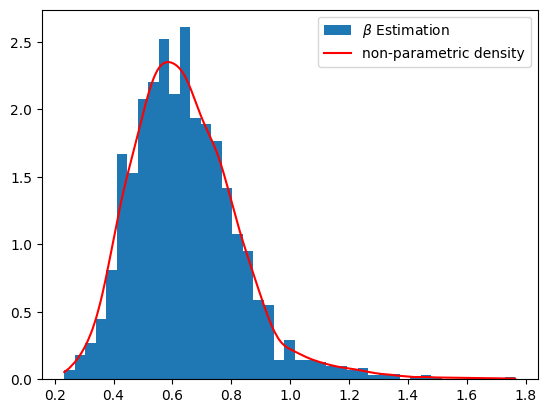

In [29]:
#Estimation de beta 
plt.hist(beta, density=True, label = r"$\beta$ Estimation", bins='auto');
plt.plot(np.sort(beta), nparam_density(np.sort(beta)), color = 'red', label = r"non-parametric density")
plt.legend();